# Feature extraction and transfer learning with pre-trained CNNs
Before proceeding *REMEMBER TO ENABLE GPU IN THE RUNTIME ENVIRONMENT:* Go to Runtime -> "Change runtime type" and select GPU as hardware acelerator.

## Task 1: Downloading images from DuckDuckGo search engine

Our starting point is to find some pictures of objects that we want our neural network to recognize. For that purpose we will be using a Python package that comes with the book ["Deep Learning for Coders"](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527). You'll first need to install that package using ``pip``:

To get a list of 100 URLs of cat images using the [DuckDuckGo](https://duckduckgo.com/) search engine, run the following code:

In [ ]:
!pip install --upgrade pip

In [ ]:
from fastbook import *
urls = search_images_ddg('cat', max_images=100)
print(f'Number of URLs: {len(urls)}')
print(f'First URL {urls[0]}')

/root/venv/lib/python3.7/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")
Number of URLs: 100
First URL https://jooinn.com/images/pussy-cat-4.jpg


To download the image corresponding to the first URL, run this:

In [ ]:
download_url(urls[0], 'data/cat.jpg')

Path('cat.jpg')

Let's display it also

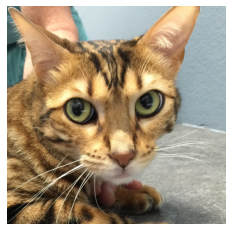

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('data/cat.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); # Recall OpenCV reads images as BGR
plt.axis('off');

## Task 2: Mount your Google Drive, create data directory, and download training images
Save this notebook to your Google Drive by selecting "Save" or "Save a copy in Drive" in the Files menu. If you want to store data permanently, you also need to mount your Google Drive, which can be done as follows:

**Note:** In my browser, the copy-button that displays next to the authorizatin code doesn't work properly. So I copied the code manually.

Create a directory to store the downloaded images in. I prefer to use [pathlab](https://docs.python.org/3/library/pathlib.html), but Google Colab also allows you to run normal shell commands like ``mkdir`` if you prefix the command with ``!`` (see ``ls`` example below).

In [ ]:
from pathlib import Path
#root = '/content/gdrive/My Drive/' # Don't change this
root = './content/' # Alternative solution if mounting your Drive doesn't work
data_dirname = 'data' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"

To check that the data directory was created successfully, you could ``ls`` the parent directory in a shell and and verify that ``data``is there:

In [ ]:
!ls -l "/content/gdrive/My Drive"  

ls: cannot access '/content/gdrive/My Drive': No such file or directory


Now, lets define the object categories that we are interested in (feel free to modify).

**IMPORTANT**: Class names must appear in alpha-numeric order to be compatible with the class assignment of the image generator below.

In [ ]:
classes = ['cat','dog','horse'] # DuckDuckGo search terms

Then download 100 images from each category (this will take some time). Note that images from each category will be placed in seperate subfolders of the data directory.

**IMPORTANT:** In case the download fails and you have to clear the data directory, uncomment and run these commands (remember to prefix with !):

```
!rm -rf "/content/data"
!mkdir "/content/data" # make new empty data directory
````

In [ ]:
# Download images
max_images = 100
count = 0
for idx, category in enumerate(classes):
  print(category)
  folder = category
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  urls = search_images_ddg(category, max_images=max_images)
  download_images(dest,urls=urls,max_pics=max_images)

cat
dog
horse


Verify images (remove files that cannot be opened)

In [ ]:
import cv2
import os
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f)) 

cat
dog
horse
Failed to open content/data/horse/00000025.jpg. Deleting file


## Task 3: Set up neural network for feature extraction
We will be using a deep learning framework, called [Keras](https://keras.io/). Keras is a high-level neural network API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), CNTK, and Theano.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, such as the [ImageNet dataset](http://www.image-net.org/) (1.4 million labeled images and 1000 different classes). If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

In our case, we will consider a convolutional neural network (CNN) trained on ImageNet. We will use the MobileNet architecture, but there are other models that you could use as well. Take a look here: https://keras.io/applications

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will be covering both of them today. Let's start with feature extraction.

Feature extraction consists of using the representations learned by an existing neural network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. This could be any classifier, such as K-Nearest Neighbours (KNN).

Traditional CNNs are divided into two parts: they start with a series of convolution and pooling layers, and they end with a densely-connected classifier. The first part is often referred to as the "encoder", "feature extractor" or "convolutional base" of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output. The second part of the network, called the "decoder" or "top layers", is ignored for now. We will be using it for fine-tuning (Transfer Learning) in Task 10.

First, let's download and instantiate the pre-trained MobileNet without the top layers (i.e., without the decoder):

**IMPORTANT:** For some reason, you may sometimes need to downgrade tensorflow to use keras. To do this, uncomment and run the following command:

In [ ]:
!pip uninstall tensorflow -y

Found existing installation: tensorflow 2.4.1
Not uninstalling tensorflow at /shared-libs/python3.7/py/lib/python3.7/site-packages, outside environment /root/venv
Can't uninstall 'tensorflow'. No files were found to uninstall.


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

conv_base = MobileNet(weights="imagenet",
                      include_top=False,
                      input_shape=(120, 120, 3))

2021-09-09 18:53:12.065802: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-09 18:53:12.065876: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-09 18:53:17.391667: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-09 18:53:17.395235: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-09 18:53:17.395255: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-09 18:53:17.395285: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

Let's summarize the model used for feature extraction:

In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 60, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 60, 60, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 60, 60, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 60, 60, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 60, 60, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 60, 60, 32) 

That's a lot to digest if you haven't seen a convolutional neural network before. By the end of the course, you will know what it all means. For now, see if you can figure out the answers to these questions:

### Questions 3.1
1. What is the expected shape of the input image?
 - 120x120x3
2. What is the shape of the output of the model?
 - 3x3x1024
3. What happens to the output shape if you double the size of the input image?
- 7x7x1024
4. Can you guess what the None dimension is used for?
 - None means this dimension is variable.
   The first dimension in a keras model is always the batch size. You don't need fixed batch sizes

### Task 4: Preprocessing
Many neural networks expect the input image to have a fixed, pre-defined shape. Also, the pixel intensities are assumed to be in a fixed range.

For reasons that will become clear later in the course, neural networks do not work well on images in which the intensities lie in the standard range from 0 to 255. Instead, we want the intensities to be centered around zero. Typical intensity ranges are -127.5 to 127.5 or -1 to 1, but it depends on the chosen neural network architecture. Each pre-trained network in Keras comes with its own *preprocessor*, which assures that the intensities are scaled correctly for that particular network.

In summary, *preprocessing* refers to the step of preparing the image to be fed into the network by making sure the image has the right shape, and that the intensities are in the correct range.

Let's load an image, preprocess it, and feed it through the network:

File path: content/data/cat/00000067.jpg
Minvalue: -1.0
Maxvalue: 1.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(1, 1, 120, 120, 3)
2021-09-09 18:53:18.893250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-09 18:53:18.925486: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199715000 Hz
(1, 3, 3, 1024)


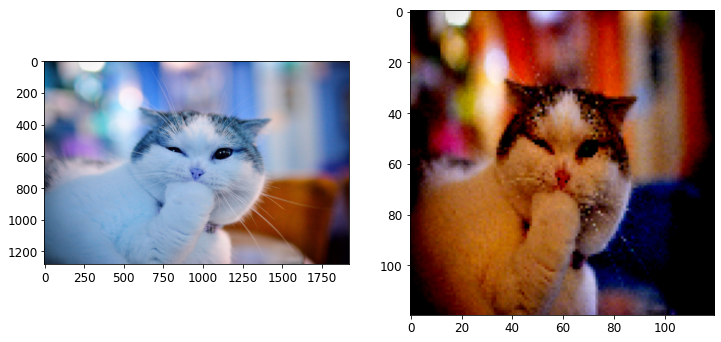

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

minValue = np.amin(img_preprocessed)
maxValue = np.amax(img_preprocessed)
print("Minvalue: " + str(minValue))
print("Maxvalue: " + str(maxValue))

imgBefore = cv2.imread(str(img_path))
plt.figure(figsize=(12,12))
plt.subplot(121);
plt.imshow(imgBefore)
plt.subplot(122);
plt.imshow(img_preprocessed[0])
expanded = np.expand_dims(img_data, axis=0)
print(expanded.shape)

# Feed preprocessed image through CNN encoder to get a new feature representation
mobilenet_features = conv_base.predict(img_preprocessed)
print(mobilenet_features.shape)

### Questions 4.1
1. What is the range of the pixel values before and after preprocessing?
- [-1,1]
2. So what formula do you think is used to pre-process the pixel values?
- (val)/(127.5)-1
3. What is the order of the color channels? (you could compare with ``cv2.imread``, which we know reads images as BGR)
- RGB
4. What is the size of the input image (``img_data`` after calling ``np.expand_dims``)?
- (1,1,120,120,3)
5. What is the size of the calculated feature representation (`mobilenet_features`)?
- (1,3,3,1024)
6. So what is the reduction in dimensionality after feature extraction?
- 1:40

## Task 5: Feature maps
As we have seen above, a convolutional neural network consists of many layers. Each layer performs some mathematical operation on the output of the previous layer. The operations have names like ``Conv2D`` , ``BatchNormalization``, ``ReLU``, and ``DepthwiseConv2D``, which you will learn about during the course.

The output of a layer is referred to as a **feature map**.

Let's look at some feature maps produced by the first layer:

Feature map size: 60x60x32


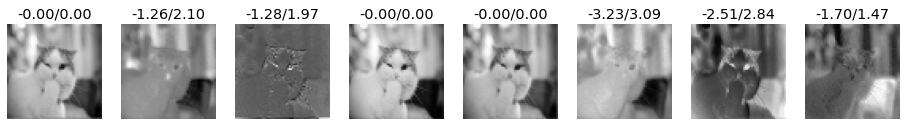

In [ ]:
from tensorflow.keras import Model

def show_feature_maps_from_layer(layer_name='conv1',img=img_preprocessed):
  dummy_model = Model(inputs=conv_base.input, outputs=conv_base.get_layer(layer_name).output) 
  out = (dummy_model.predict(img)).squeeze()
  height = out.shape[0]
  width = out.shape[1]
  num_channels = out.shape[2]
  print(f'Feature map size: {height}x{width}x{num_channels}')

  plt.figure(figsize=(16,16))
  for i in range(8): # only display first 8 feature maps (channels)
    f = out[:,:,i]
    plt.subplot(1,8,i+1)
    plt.imshow(f,cmap='gray')
    plt.axis('off')
    plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

# See conv_base.summary() for complete list of layer names
show_feature_maps_from_layer(layer_name='conv1')

Because this layer (``conv1``) is a convolution layer, each feature map results from applying a filter to the input image. As you can see, different filters highlight different features of the input image. The next layer in the network then takes these feature maps and transforms them somehow to extract new and more abstract features. In one of the later layers (``conv_dw_2``) we can still sort-of see the cat in the feature maps:

Feature map size: 30x30x64


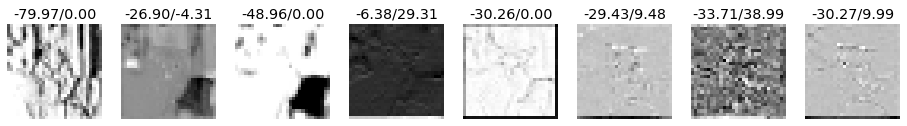

In [ ]:
show_feature_maps_from_layer(layer_name='conv_dw_2')

In the last feature map it is impossible for us to see that there was originally a cat in the input image:

Feature map size: 3x3x1024


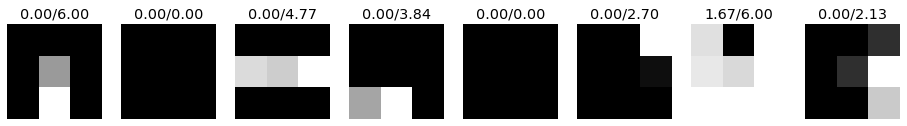

In [ ]:
show_feature_maps_from_layer(layer_name='conv_pw_13_relu')

### Question 5.1
1. Notice that the height and width of the feature maps become smaller and smaller as we move deeper into the network. Why do you think that is?
- Because they describe more and more specific features
2. If the last feature map is only three pixels high and three pixels wide (shape is ``3x3x1024``), how can the neural network know that there is a cat in the image, i.e, where is that information encoded in the feature map?
- Since each feature become more and more advanced (depending on earlier features) each feature in the output may even itself denote the high level information of there being a cat in the image.

### Task 6: How to use the image generator 
Loading and preprocessing images is such a common task in deep learning that frameworks like Keras provide predefined tools for us that we can use. 
In this task we will look at Keras' image data generator: https://keras.io/preprocessing/image/#imagedatagenerator-class. Simply put, the image generator is a tool that makes loading and preprocessing data easy.

Let's set up an image generator that outputs mini-batches of 8 images:


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True)

Found 479 images belonging to 3 classes.


**Note:** Check that the classes assigned by the generator are consistent with your class assignment:

In [ ]:
print('generator:',generator.class_indices)
print('your\'s:',dict((class_name,class_index) for class_index,class_name in enumerate(classes)))

generator: {'cat': 0, 'dog': 1, 'horse': 2}
your's: {'cat': 0, 'dog': 1, 'horse': 2}


Here is one way to generate a new batch:

In [ ]:
inputs, labels = generator.next()
print(inputs.shape)
print(labels)

(8, 120, 120, 3)
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Questions 6.1
1. What is variable ``inputs``? (Hint: look at the shape)
- 8 images of size 120x120x3
2. What is variable ``labels``?
- one-in-k encoding of the label for each image
3. How does the image generator know where the images are stored?
- It is given the main data folder as a parameter
4. How does the image generator know the class of each image?
- We made sure to have our folder names in alphebetical order, such that the generator gets the correct class assignments
5. What does shuffle mean?
- Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.

As you learned in lecture 2 it is always a good idea to split the data into a training set and a validation set. Again, this is such a common task in deep learning that the image generator can do it for us:

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 384 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


### Questions 6.2
1. How does each of the two generators know if it should produce training or validation images?
- It's given a subset name
2. What is the validation percentage in this example?
- 20%

## Task 7: Feature extraction
Our goal is to train a machine learning model to correctly classify images belonging to the chosen categories (cat, dog, horse). Today, we will be using KNN, which operates on vectors. Therefore, we have to convert our images into vectors.

We have two choices of features:

1. Raw pixel values
2. MobileNet features

Besides the features we will of course also need the labels (cat, dog, horse).

Let's create the datasets that we will be using:


In [ ]:
def extract_features(generator):
  generator.reset()
  raw_pixel_features_list = []
  mobilenet_features_list = []
  labels_list = []
  batch_index = 0
  while batch_index <= generator.batch_index:
    # Load mini-batch
    raw_pixels, labels = generator.next()

    # Run through MobileNet encoder
    mobilenet_features = conv_base.predict(raw_pixels) # This is where we apply the CNN

    # Vectorize images
    bs,h,w,c = raw_pixels.shape
    raw_pixels = np.reshape(raw_pixels,(bs,h*w*c)) # vectorize
    
    # Vectorize MobileNet features
    bs,h,w,c = mobilenet_features.shape
    mobilenet_features = np.reshape(mobilenet_features,(bs,h*w*c)) # vectorize
    
    # Convert one-hot encoding to class index
    labels = np.argmax(labels,axis=1)

    # Save in lists
    for i in range(bs):
      raw_pixel_features_list.append(raw_pixels[i])
      mobilenet_features_list.append(mobilenet_features[i])
      labels_list.append(labels[i])
      
    batch_index = batch_index + 1

  # Convert lists to numpy arrays
  raw_pixel_features = np.asarray(raw_pixel_features_list)
  mobilenet_features = np.asarray(mobilenet_features_list)
  labels = np.asarray(labels_list)

  return raw_pixel_features, mobilenet_features, labels

In [ ]:
train_features_raw, train_features_mobilenet, train_labels = extract_features(train_generator)
validation_features_raw, validation_features_mobilenet, validation_labels = extract_features(validation_generator)

Show the first 32 images of the validation data set:

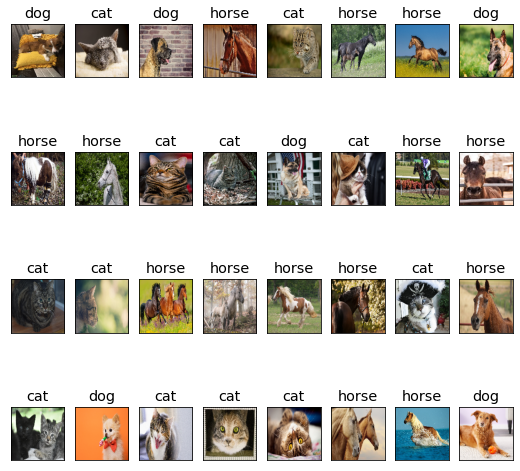

In [ ]:
def denormalize(input_img):
  '''
    input_img has intensities in range -1 to 1 (after Keras MobileNet preprocessing)
    output_img has intensities in range 0 to 1 (float)
  '''
  output_img = (input_img+1) / 2
  return output_img

def vec2img(img_as_vec,output_shape=(120,120,3)):
  '''
    img_as_vec is a vectorized color image
    output_shape is the desired output image shape
  '''
  img_as_array = np.reshape(img_as_vec,output_shape)
  return img_as_array

plt.figure(figsize=(9,9))
for i in range(32):
  # reshape feature vector into 120x120x3 array (image) and de-normalize intensities to range 0 to 1.
  img = vec2img(validation_features_raw[i,:])
  img = denormalize(img)
  plt.subplot(4,8,i+1)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])
  plt.title(classes[int(validation_labels[i])])

**Sub-task:** Verify that the labels above are correct

In [ ]:
print("raw: " + str(train_features_raw.shape))
print("raw_val: " + str(validation_features_raw.shape))
print("mobilenet: " + str(train_features_mobilenet.shape))
print("train-labels: " + str(train_labels.shape))

print("val-labels: " + str(validation_labels.shape))

raw: (384, 43200)
raw_val: (95, 43200)
mobilenet: (384, 9216)
train-labels: (384,)
val-labels: (95,)


### Questions 7.1
The image data has now been vectorized.
1. What is the shape of ``train_features_raw``?
- (356, 43200)
2. What is the shape of ``train_features_mobilenet``?
- (356, 9216)
3. What is the difference between ``train_features_raw`` and ``train_features_mobilenet``, i.e., what do they represent?
- Funny enough 3x3x1024 = 9216, and 120x120x3 = 43200
4. What is the shape of ``train_labels``?
- (356,)
5. How many training samples do we have, and how many validation samples?
- 356 training, 88 validation

## Task 8: Classify images using K-Nearest Neighbours (K-NN) classifier
Your task is to train a K-NN classifier on the training set, and evaluate the performace on the validation set by calculating the accuracy (and remember to calculate the accuracy on the validation set, not the training set!).

First solve the task using the raw pixels as features:

```
# Training set
train_features_raw, train_labels

# Validation set
validation_features_raw, validation_labels
```

Then solve the same task using the MobileNet features:

```
# Training set
train_features_mobilenet, train_labels

# Validation set
validation_features_mobilenet, validation_labels
```

Compare the results and explain the difference.

You are on your own here, but **you don't have to implement K-NN yourself**. I suggest you use [scikit-learn](https://scikit-learn.org) (and Google).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_features_raw, train_labels)
acc_raw = neigh.score(validation_features_raw, validation_labels)
print("acc_raw: " + str(acc_raw))


acc_raw: 0.6105263157894737


In [ ]:

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_features_mobilenet, train_labels)
acc_mobile = neigh.score(validation_features_mobilenet, validation_labels)
print("acc_mobile: " + str(acc_mobile))


acc_mobile: 0.8842105263157894


### Task 9: K-means clustering
So what we have learned so far is that images of the same class tend to group closer together when using MobileNet's feature representation, but not so much when using the raw intensities. This confirms that using the raw pixels as features is in general not a good idea.

The reason that MobileNet's feature representation works better is because the network has learned to map images onto a manifold. A manifold is kind of like a low-dimensional surface that exists in a high-dimensional space. For instance if images of faces were to be mapped into a 4D manifold, the first axis on the manifold could represent gender, and the others could represent age, view angle, and eye color. You can read more about manifold learning in chapter 5.11.3 of [the book](https://github.com/janishar/mit-deep-learning-book-pdf).

The underlying hypothesis of using K-NN to classifiy images using MobileNet features is that *objects that are similar will map to the approximate same location on some manifold.* Here we will perform K-means clustering and verify that this is in fact the case. For the record, recall that the K-means method is an *undersupervised learning method*, so it doesn't know anything about the class labels.

**Your task** is to perform K-means clustering twice on your training dataset: first using the raw intensity features (``train_features_raw``), then using the MobileNet features (``train_features_mobilenet``). Use as many clusters as you have classes, which is 3 if you also used cat, dog, and horse.

For each cluster, print the class labels (cat, dog, horse) or the class indices (0, 1, 2) of all images in that cluster. Explain what you observe and compare between MobileNet features and raw pixel intensities.

**Note** that we wont be needing the validation set in this task. Why? Because K-means is an unsupervised learning method often used to perform exploratory data analysis. Here we are pretending that we dont know the true labels. We are just interested in seeing if the image data form clusters or not.

Again, **you don't have to implement K-means clustering from scratch**. You can use scikit-learn (and Google).



In [ ]:
from sklearn.cluster import KMeans

kmeans_raw = KMeans(n_clusters=3).fit(train_features_raw)
kmeans_mobilenet = KMeans(n_clusters=3).fit(train_features_mobilenet)

In [ ]:
print("raw:")
for cluster in range(3):
    print("Cluster: " + str(cluster))
    my_members_raw = kmeans_raw.labels_ == cluster
    
    my_labels_raw = train_labels[my_members_raw]
    print("Number of cats: " + str(np.count_nonzero(my_labels_raw == 0)))
    print("Number of dogs: " + str(np.count_nonzero(my_labels_raw == 1)))
    print("Number of horses: " + str(np.count_nonzero(my_labels_raw == 2)))
    
print("mobilenet:")
for cluster in range(3):
    print("Cluster: " + str(cluster))
    my_members_mobilenet = kmeans_mobilenet.labels_ == cluster
    
    my_labels_mobilenet = train_labels[my_members_mobilenet]
    print("Number of cats: " + str(np.count_nonzero(my_labels_mobilenet == 0)))
    print("Number of dogs: " + str(np.count_nonzero(my_labels_mobilenet == 1)))
    print("Number of horses: " + str(np.count_nonzero(my_labels_mobilenet == 2)))

raw:
Cluster: 0
Number of cats: 27
Number of dogs: 57
Number of horses: 77
Cluster: 1
Number of cats: 20
Number of dogs: 10
Number of horses: 31
Cluster: 2
Number of cats: 49
Number of dogs: 33
Number of horses: 80
mobilenet:
Cluster: 0
Number of cats: 0
Number of dogs: 6
Number of horses: 124
Cluster: 1
Number of cats: 81
Number of dogs: 7
Number of horses: 0
Cluster: 2
Number of cats: 15
Number of dogs: 87
Number of horses: 64


Two of the clusters created by mobilenet separates cats and horses very well and only a few dogs get in the mix. There is still a lot of errors for the third cluster which is supposedly for dogs, a lot of horses and cats also end up in this category.

The raw data using pixel intensities does not create a good clustering of the data.

## Task 10: Image retrieval
Implement an image search engine (this is also called image retrieval). Use MobileNet features, and if you have time do a comparison with raw pixel features.

The search engine could work like this:

1. Given an input image from the validation set, pre-process it and feed it through MobileNet to calculate the feature vector.
2. Then perform a K-NN search with K=10 against the feature vectors in the training set.
3. Then return the corresponding 10 closest images.

In principle we should preprocess the input image like this:
```
img = image.load_img(some_image_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data)
```
But it is okay to cheat and use the image data that have already been preprocessed and run through MobileNet.

**Question:** What kind of search results do you expect to see when using MobileNet features vs. using raw pixel features?

In [ ]:
def image_search_mobilenet(path, n=10):
    #Load
    img = image.load_img(path, target_size=(120,120))
    img_data = image.img_to_array(img)
    #Preprocess
    img_data = np.expand_dims(img_data, axis=0)
    img_preprocessed = preprocess_input(img_data)
    #MobileNet
    # Run through MobileNet encoder
    mobilenet_feature = conv_base.predict(img_preprocessed) # This is where we apply the CNN
    # Vectorize MobileNet features
    bs,h,w,c = mobilenet_feature.shape
    mobilenet_feature = np.reshape(mobilenet_feature,(bs,h*w*c)) # vectorize
    #K-NN
    _, neighbors = neigh.kneighbors(mobilenet_feature, n_neighbors=n)
    return neighbors.flatten()


In [ ]:
def show_pictures(indexes, original):
    plot_rows = math.ceil((len(indexes)+1)/8)
    plt.figure(figsize=(9,plot_rows+1))
    plt.subplot(plot_rows,8,1)
    original_image = cv2.imread(str(original))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    plt.title(original)
    for index, image_index in enumerate(indexes):
        # reshape feature vector into 120x120x3 array (image) and de-normalize intensities to range 0 to 1.
        image_vector = train_features_raw[image_index,:]
        img = vec2img(image_vector)
        img = denormalize(img)
        plt.subplot(plot_rows,8,index+2)
        plt.imshow(img)
        plt.xticks([]), plt.yticks([])
        plt.title(classes[int(train_labels[image_index])])

Finding 10 nearest neighbors for cat.jpg


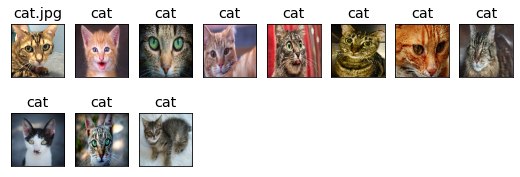

In [ ]:
print("Finding 10 nearest neighbors for cat.jpg")

neighbor_indexes = image_search_mobilenet("data/cat.jpg", 10)
show_pictures(neighbor_indexes, "data/cat.jpg")

## Task 11: Transfer learning


Putting your own K-NN classifier on top of a pre-trained CNN is not really optimal. Why? Because, while the features of the convolutional base are better than using raw pixel values, they are not guaranteed to 100% optimal for your specific task. So, a better solution is to attach a second neural network on top of the convolutional base, and train both the classifier *and* the convolutional base at the same time. This is called **transfer learning**. The extra neural network that is put on top of our encoder is often referred to as a "decoder" or a "classification head".

Recall that CNNs like AlexNet and MobileNet have been trained on ImageNet, which contains 1000 classes. If you download Keras' pre-trained models *including the top layers* (i.e., the decoder), the top layers are in fact the classifier that we want to replace. Let's verify this:

In [ ]:
mobilenet_full = MobileNet(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))
mobilenet_full.summary()

### Questions 11.1
Inspect the printout above.
1.  Can you identify the convolutional base of this network? (Compare to the ```conv_base``` model we used earlier.)
2. All layers beyond the convolutional base represent the classifier (or decoder). How many classes are there?
3. So what is the size of the output of the model?
4. Can you guess how we should interpret the output of model?
5. The input size must be 224 by 224 pixels (you can verify for yourself). Why do you think that is? 

So, how do we modify and re-train MobileNet to work on our own data? First of all, we don't want to train CNNs from scratch, since this could take days. Secondly, we need to modify the network architecture to output three class labels (cat, dog, horse) instead of 1000.

The main hypothesis underlying transfer learning is that the network weights learned in the convolutional layers (i.e., the *encoder*) are generic and need little or no fine-tuning to work on other data sets or tasks. So in practice, we just need to replace and re-train the last layers (i.e., the *decoder*) of a pre-trained network.

So let's take our convolutional base (encoder) and put a simple neural network classifier (decoder) on top of it. Your task is to figure out what the value of variable N should be.

In [ ]:
N = ???

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Note that the weights of the new dense layers are initialized with random values. So we need to train the dense layers on our dataset to make it work.

### Questions 11.2
1. What should N be in the above code block?
2. Re-run the code block with the correct N.
3. What does GlobalAveragePooling2D do?

Hint: You can print all layers and print properties like name, type and input shape:

In [ ]:
for i,layer in enumerate(model.layers):
  layer_name = layer.name
  layer_type = layer.__class__.__name__
  input_shape = layer.input_shape
  print(f"Layer {i} has name {layer_name} and type {layer_type}, and its input shape is {input_shape}")
  
# Or use the summary function:
model.summary()

We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:

In [ ]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


We are now ready to start training the model using
- Adam optimizer
- loss function will be categorical cross entropy
- evaluation metric will be accuracy


In [ ]:
from tensorflow.keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

### Questions 11.3
Look at the outputs of the training.

1. What is the difference between 'loss' and 'val_loss'?
2. What is the difference between 'accuracy' and 'val_accuracy'?
3. Do they behave the same, or do they behave differently? Try to explain what you see.

## Task 12: Deploying the model
Here is how to deploy the model and integrate with OpenCV.

In [ ]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Remember to convert to RGB
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img);
plt.axis('off');

Now, make sure that the image shape and the pixel intensity range is as expected by the network (required shape = `1x120x120x3` and intensity range from -1 to 1):

In [ ]:
img = cv2.resize(img, (120, 120))
img = (img[...,::-1].astype(np.float32))
img /= 127.5
img -= 1.
img = np.expand_dims(img,0)
print(img.shape,img.min(),img.max())

Run the image through the network:

In [ ]:
class_probabilities = model.predict(img)[0]
print(class_probabilities)

In [ ]:
# pick class with highest probability
class_index = (-class_probabilities).argsort()[0]
print(f'The image displays a {classes[class_index]}!')

## Ideas for further work
1. In the above example we have not optimized the pre-trained weights of the convolutional base (i.e., the encoder). To improve performance further you could enable training in all layers (including the convolutoinal base) and re-train the network. This is called *fine-tuning*.
2. Another way to improve model performance is by *data augmentation*. Have a look [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to see what kind of augmentation is possible. Why do you think data augmentation helps improve the performance of your model?

## Exporting to TensorFlow JS and hosting a web service on GitHub
If you wanted to, you could in principle deploy your model and make a nice web service like this one:
https://klaverhenrik.github.io/transferlearning/. The webpage is hosted on GitHub using [GitHub Pages](https://pages.github.com/).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c87fb65-b84c-4ca8-81c4-85560a342567' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>